In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from moist_thermodynamics import functions as mt
from moist_thermodynamics import constants

# Examples

Usage of the moist thermodynamic functions is documented through a number of examples

1. constructing a moist adiabat.
2. sensitivity of moist adiabat to saturation vapor pressure 
3. lcl computations

## 1. Constructing a moist adiabat

This shows how simple it is to construct a moist adiabat.  For the example it is constructed by assuming a constant $\theta_\mathrm{l}$ but the same answer (with the caveats of the next example) would arise if we were to define it in terms of constant $\theta_\mathrm{e}$ or $\theta_\mathrm{s}$

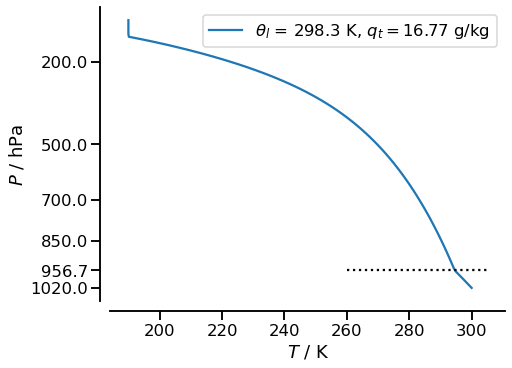

In [4]:
es      = mt.es_liq
p2q     = mt.partial_pressure_to_specific_humidity
theta_l = mt.theta_l
Tl2T    = np.vectorize(mt.T_from_Tl)

Psfc = 102000.
Tsfc = 300.
Tmin = 190.
dP   = 1000.
P    = np.arange(Psfc,0.4e4,-dP)

RH   = 0.77
qt   = p2q(RH*es(Tsfc),Psfc)

sns.set_context('talk')
fig, ax = plt.subplots(figsize = (7,5), constrained_layout = True)

Tl  = theta_l(Tsfc,Psfc,qt)
TK  = np.maximum(Tl2T(Tl,P,qt),Tmin)
ax.plot(TK,P/100.,label=f"$\\theta_l$ = {Tl:.1f} K, $q_t = ${1000*qt:.2f} g/kg")

Plcl = mt.plcl(Tsfc,Psfc,qt).squeeze()/100.

ax.hlines(Plcl,260,305.,ls='dotted',color='k')
ax.set_yticks([Psfc/100,Plcl,850.,700,500,200])
plt.gca().invert_yaxis()
plt.legend()

ax.set_xlabel("$T$ / K")
ax.set_ylabel("$P$ / hPa")
#plt.grid()
sns.despine(offset=10)

## 2. Sensitivity (small) of moist adiabat on saturation vapor pressure 

The derivation of the moist potential temperatures assumes a Rankine fluid, i.e., constant specific heats. Specific heats vary with temperature however, especially $c_i$.  This variation is encoded in the best fits to the saturation vapor pressure, so that an adiabat defined in terms of a best fit saturation vapor pressure will differ depending on whether it assumes $\theta_\mathrm{e},$ $\theta_\mathrm{l},$ or $\theta_\mathrm{s}.$  This sensitivity vanishes (right plot, note $x$-axis scale) when we replace the more accurate saturation vapor pressures with less accurate expressions, albeit consistent with a Rankine fluid.

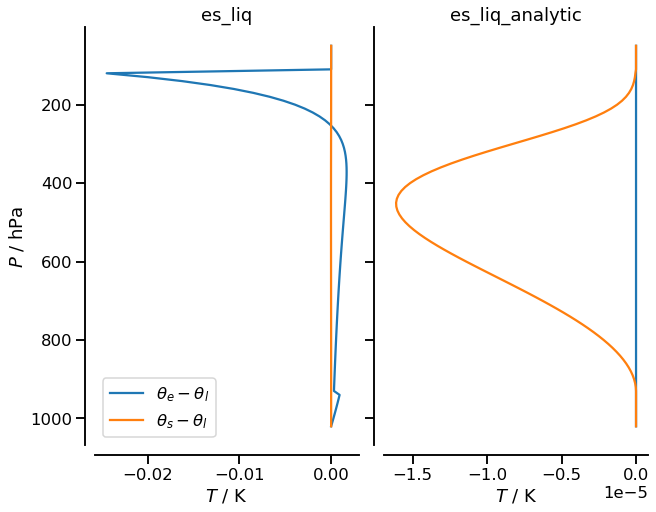

In [5]:
theta_e, theta_l, theta_s = mt.theta_e, mt.theta_l, mt.theta_s
Te2T, Tl2T, Ts2T          = np.vectorize(mt.T_from_Te), np.vectorize(mt.T_from_Tl), np.vectorize(mt.T_from_Ts)

Tmin = 190.
dP   = 1000.
P    = np.arange(Psfc,0.4e4,-dP)

Psfc = 102000.
Tsfc = 300.
qt   = 15.e-3

sns.set_context('talk')
fig, ax = plt.subplots(1,2, figsize = (9,7), constrained_layout = True, sharey=True)

es   = mt.es_liq_analytic
TKl  = np.maximum(Tl2T(theta_l(Tsfc,Psfc,qt,es=es),P,qt,es=es),Tmin)
TKe  = np.maximum(Te2T(theta_e(Tsfc,Psfc,qt,es=es),P,qt,es=es),Tmin)
TKs  = np.maximum(Ts2T(theta_s(Tsfc,Psfc,qt,es=es),P,qt,es=es),Tmin)
ax[1].plot(TKe-TKl,P/100.,label=f"$\\theta_e-\\theta_l$")
ax[1].plot(TKs-TKl,P/100.,label=f"$\\theta_s-\\theta_l$")
ax[1].set_title('es_liq_analytic')

es   = mt.es_liq
TKl  = np.maximum(Tl2T(theta_l(Tsfc,Psfc,qt,es=es),P,qt,es=es),Tmin)
TKe  = np.maximum(Te2T(theta_e(Tsfc,Psfc,qt,es=es),P,qt,es=es),Tmin)
TKs  = np.maximum(Ts2T(theta_s(Tsfc,Psfc,qt,es=es),P,qt,es=es),Tmin)
ax[0].plot(TKe-TKl,P/100.,label=f"$\\theta_e-\\theta_l$")
ax[0].plot(TKs-TKl,P/100.,label=f"$\\theta_s-\\theta_l$")
ax[0].set_title('es_liq')

plt.gca().invert_yaxis()

ax[0].set_xlabel("$T$ / K")
ax[1].set_xlabel("$T$ / K")

ax[0].set_ylabel("$P$ / hPa")
ax[0].legend()

sns.despine(offset=10)

## 3. Calculations of lifting condensation level

We compare three different formulations of the lifting condensation level, one due to Romps (2017) is not included in the moist_thermodynamics library, but is included here for sake of comparision.  The analysis shows that the simple bolton approximations work very well, as well as those of Romps if one uses the wagner saturation vapor pressure data.  Had we performed this comparison with the analytic formula using the specific heats specified by Romps, the comparison would have been more favorable for the Romps formulation.

In [6]:
# Version 1.0 released by David Romps on September 12, 2017.
# 
# When using this code, please cite:
# 
# @article{16lcl,
#   Title   = {Exact expression for the lifting condensation level},
#   Author  = {David M. Romps},
#   Journal = {Journal of the Atmospheric Sciences},
#   Year    = {2017},
#   Volume  = {in press},
# }
#
# This lcl function returns the height of the lifting condensation level
# (LCL) in meters.  The inputs are:
# - p in Pascals
# - T in Kelvins
# - Exactly one of rh, rhl, and rhs (dimensionless, from 0 to 1):
#    * The value of rh is interpreted to be the relative humidity with
#      respect to liquid water if T >= 273.15 K and with respect to ice if
#      T < 273.15 K. 
#    * The value of rhl is interpreted to be the relative humidity with
#      respect to liquid water
#    * The value of rhs is interpreted to be the relative humidity with
#      respect to ice
# - ldl is an optional logical flag.  If true, the lifting deposition
#   level (LDL) is returned instead of the LCL. 
# - min_lcl_ldl is an optional logical flag.  If true, the minimum of the
#   LCL and LDL is returned.

def lcl(p,T,rh=None,rhl=None,rhs=None,return_ldl=False,return_min_lcl_ldl=False):

    import math
    import scipy.special

    # Parameters
    Ttrip = 273.16     # K
    ptrip = 611.65     # Pa
    E0v   = 2.3740e6   # J/kg
    E0s   = 0.3337e6   # J/kg
    ggr   = 9.81       # m/s^2
    rgasa = 287.04     # J/kg/K 
    rgasv = 461        # J/kg/K 
    cva   = 719        # J/kg/K
    cvv   = 1418       # J/kg/K 
    cvl   = 4119       # J/kg/K 
    cvs   = 1861       # J/kg/K 
    cpa   = cva + rgasa
    cpv   = cvv + rgasv

    # The saturation vapor pressure over liquid water
    def pvstarl(T):
        return ptrip * (T/Ttrip)**((cpv-cvl)/rgasv) * math.exp( (E0v - (cvv-cvl)*Ttrip) / rgasv * (1/Ttrip - 1/T) )
    # The saturation vapor pressure over solid ice
    def pvstars(T):
        return ptrip * (T/Ttrip)**((cpv-cvs)/rgasv) *  math.exp( (E0v + E0s - (cvv-cvs)*Ttrip) / rgasv * (1/Ttrip - 1/T)) 

    # Calculate pv from rh, rhl, or rhs
    rh_counter = 0
    if rh  is not None:
        rh_counter = rh_counter + 1
    if rhl is not None:
        rh_counter = rh_counter + 1
    if rhs is not None:
        rh_counter = rh_counter + 1
    if rh_counter != 1:
        print(rh_counter)
        exit('Error in lcl: Exactly one of rh, rhl, and rhs must be specified')
    if rh is not None:
    # The variable rh is assumed to be 
    # with respect to liquid if T > Ttrip and 
    # with respect to solid if T < Ttrip
        if T > Ttrip:
            pv = rh * pvstarl(T)
        else:
            pv = rh * pvstars(T)
            rhl = pv / pvstarl(T)
            rhs = pv / pvstars(T)
    elif rhl is not None:
        pv = rhl * pvstarl(T)
        rhs = pv / pvstars(T)
        if T > Ttrip:
            rh = rhl
        else:
            rh = rhs
    elif rhs is not None:
        pv = rhs * pvstars(T)
        rhl = pv / pvstarl(T)
        if T > Ttrip:
            rh = rhl
        else:
            rh = rhs
    if pv > p:
        return N

# Calculate lcl_liquid and lcl_solid
    qv = rgasa*pv / (rgasv*p + (rgasa-rgasv)*pv)
    rgasm = (1-qv)*rgasa + qv*rgasv
    cpm = (1-qv)*cpa + qv*cpv
    if rh == 0:
        return cpm*T/ggr
    aL = -(cpv-cvl)/rgasv + cpm/rgasm
    bL = -(E0v-(cvv-cvl)*Ttrip)/(rgasv*T)
    cL = pv/pvstarl(T)*math.exp(-(E0v-(cvv-cvl)*Ttrip)/(rgasv*T))
    aS = -(cpv-cvs)/rgasv + cpm/rgasm
    bS = -(E0v+E0s-(cvv-cvs)*Ttrip)/(rgasv*T)
    cS = pv/pvstars(T)*math.exp(-(E0v+E0s-(cvv-cvs)*Ttrip)/(rgasv*T))
    X  = bL/(aL*scipy.special.lambertw(bL/aL*cL**(1/aL),-1).real)
    Y  = bS/(aS*scipy.special.lambertw(bS/aS*cS**(1/aS),-1).real) 
    
    lcl = cpm*T/ggr*( 1 - X)
    ldl = cpm*T/ggr*( 1 - Y)

    # Modifications of the code to output Plcl or Pldl
    Plcl = PPa * X**(cpm/rgasm)
    Pldl = PPa * X**(cpm/rgasm)
    # Return either lcl or ldl
    if return_ldl and return_min_lcl_ldl:
        exit('return_ldl and return_min_lcl_ldl cannot both be true')
    elif return_ldl:
        return Pldl
    elif return_min_lcl_ldl:
        return min(Plcl,Pldl)
    else:
        return Plcl

/Users/m219063/opt/miniforge3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


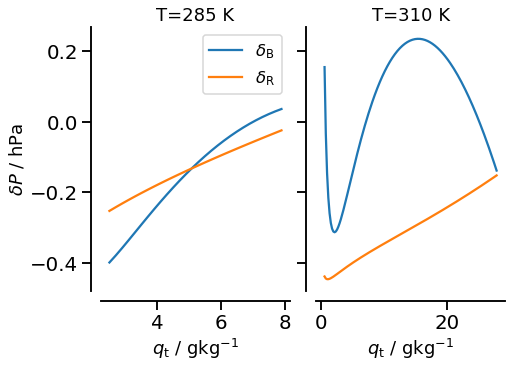

In [7]:
PPa  = 101325.
qt   = np.arange(2.5e-3,8.e-3,0.2e-3)
TK   = 285.
Plcl_X = np.zeros(len(qt))
Plcl_B = np.zeros(len(qt))
Plcl_R = np.zeros(len(qt))

for i,x in enumerate(qt):
    RH        = mt.mixing_ratio_to_partial_pressure(x/(1.-x),PPa)/mt.es_liq(TK)
    Plcl_R[i] = lcl(PPa,TK,RH)
    Plcl_X[i] = mt.plcl(TK,PPa,x)
    Plcl_B[i] = mt.plcl_bolton(TK,PPa,x)

del1 = (Plcl_B-Plcl_X)/100.
del2 = (Plcl_R-Plcl_X)/100.

fig, axs = plt.subplots(1,2, figsize = (7,5), constrained_layout = True, sharey=True)

axs[0].plot(qt*1.e3,del1,label='$\\delta_\mathrm{B}$')
axs[0].plot(qt*1.e3,del2,label='$\\delta_\mathrm{R}$')
axs[0].legend(loc="best")
axs[0].set_ylabel('$\delta P$ / hPa')
axs[0].set_xlabel('$q_\mathrm{t}$ / gkg$^{-1}$')
axs[0].set_title(f'T={TK:.0f} K')

qt = np.arange(0.5e-3,28.e-3,0.2e-3)
TK = 310.

Plcl_X = np.zeros(len(qt))
Plcl_B = np.zeros(len(qt))
Plcl_R = np.zeros(len(qt))
for i,x in enumerate(qt):
    RH        = mt.mixing_ratio_to_partial_pressure(x/(1.-x),PPa)/mt.es_liq(TK)
    Plcl_R[i] = lcl(PPa,TK,RH)
    Plcl_X[i] = mt.plcl(TK,PPa,x)
    Plcl_B[i] = mt.plcl_bolton(TK,PPa,x)

del1 = (Plcl_B-Plcl_X)/100.
del2 = (Plcl_R-Plcl_X)/100.

axs[1].plot(qt*1.e3,del1)
axs[1].plot(qt*1.e3,del2)
axs[1].set_xlabel('$q_\mathrm{t}$ / gkg$^{-1}$')
axs[1].set_title(f'T={TK:.0f} K')

sns.set_context("talk", font_scale=1.2)
sns.despine(offset=10)
#fig.savefig(plot_dir+'Plcl.pdf')